In [1]:
import torch
import os
import torch.optim as optim
import torch.utils.data as data
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sys.path.append('/remote/tychodata/ftairli/work/Projects/MuonSignal/Models')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using ',device)



Using  cuda:0


In [243]:
# Load Data

Main = torch.load('../Data/NormData/Main_train.pt')
Aux   = torch.load('../Data/NormData/Aux_train.pt')
Truth = torch.load('../Data/NormData/Truth_train.pt')
EventMyId = torch.load('../Data/NormData/EventMyId_train.pt')

Main = Main.transpose(1,2)
# Truth = Truth.sum(dim=1).unsqueeze(1)
print(Main.shape, Aux.shape, Truth.shape)

torch.Size([1506746, 120, 3]) torch.Size([1506746, 4]) torch.Size([1506746, 120])


In [344]:
class Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=1):
        super(Model, self).__init__()
        # Info
        self.Name = 'Model'
        self.Description ='''
        HandCranking time
        '''
        self.LSTM = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
    def forward(self, trace,aux,Unnorm=False):
        
        trace = trace.mean(dim=2).unsqueeze(2)
        
        out1, out2 = self.LSTM(trace)
       
        return out1, out2

model = Model().to(device)

In [345]:
# Setup here
LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
BatchSize =1000
from Model_1_0 import MyDataset
Dataset = MyDataset(Main,Aux,Truth)
DataLoader = data.DataLoader(Dataset, batch_size=BatchSize, shuffle=True, drop_last=True)



In [346]:
def MyLoss(Pred,Truth):
    assert Pred.shape[1:] == torch.Size([120,1]), 'Pred shape is {}'.format(Pred.shape)
    assert Truth.shape[1:] == torch.Size([120,1]), 'Truth shape is {}'.format(Truth.shape)
    assert Pred.shape[0] == Truth.shape[0] , 'Batch Size doesnt Match o_0'

    Loss = nn.MSELoss(Pred,Truth)
    return Loss



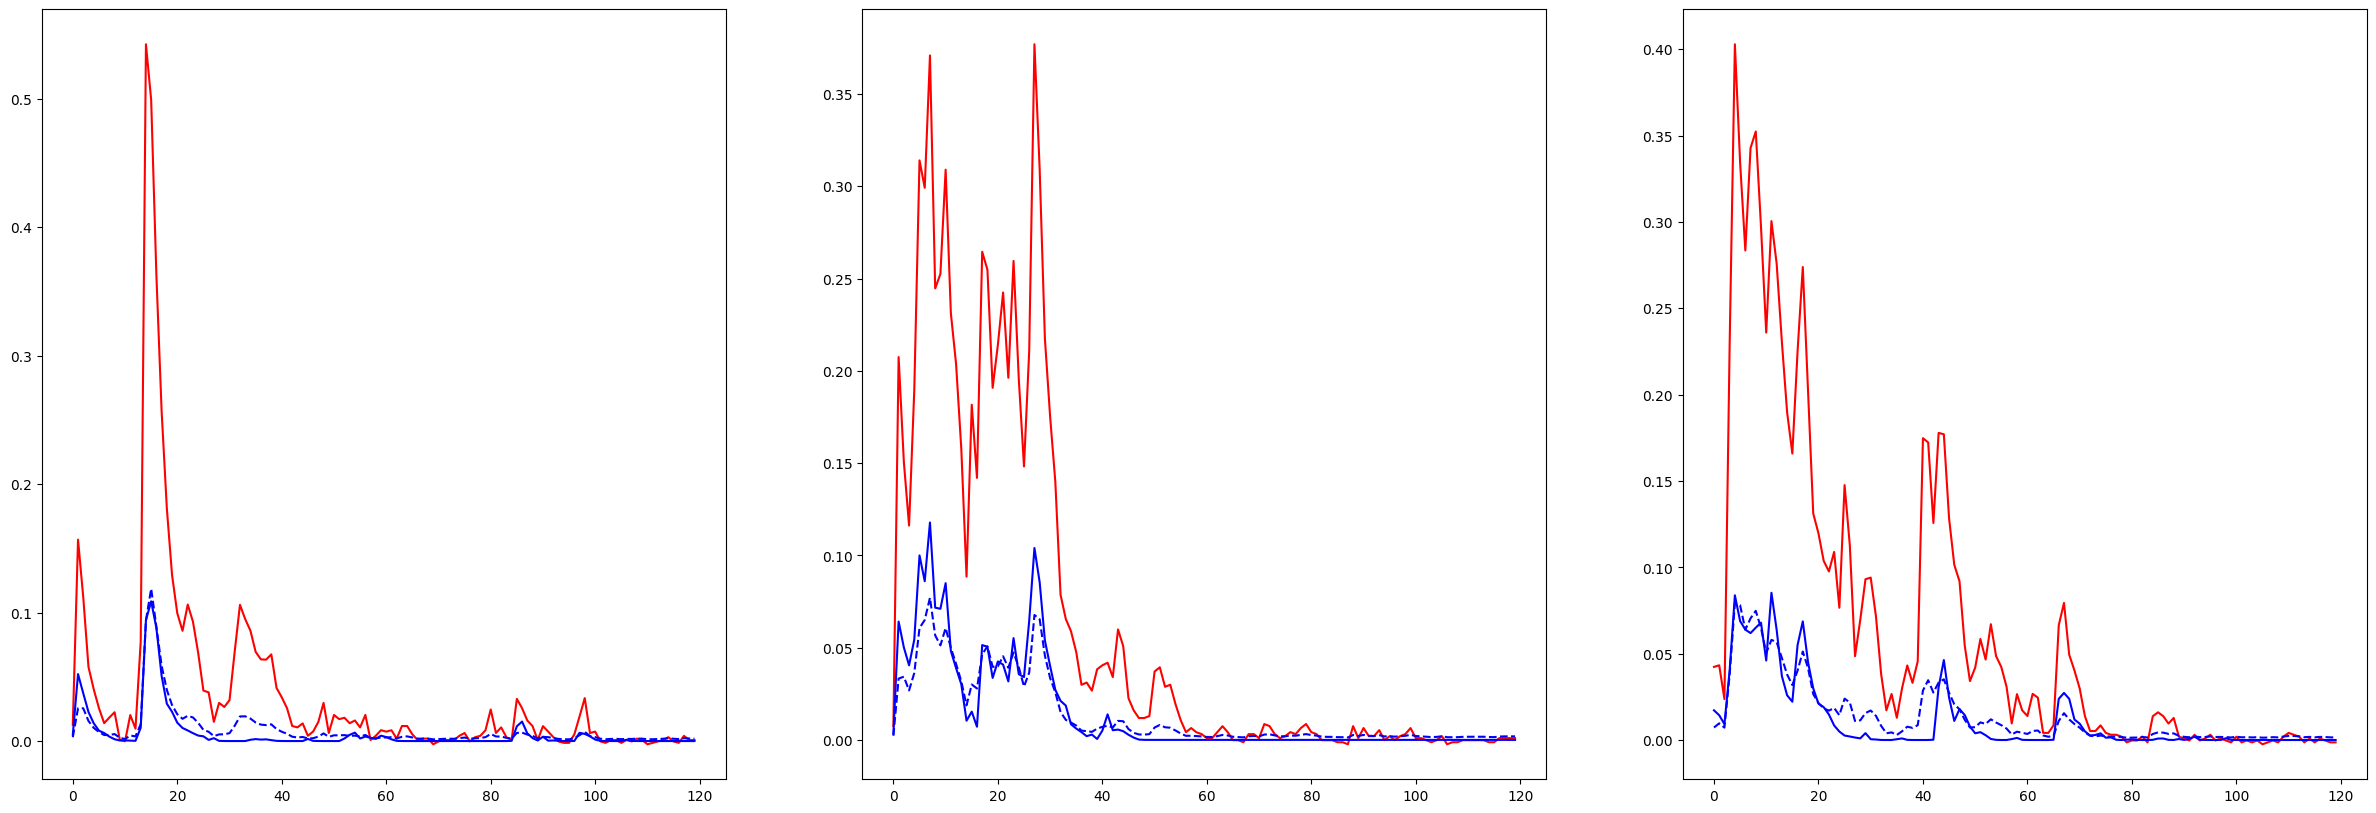

In [373]:
BatchMain,BatchAux,BatchTruth = next(iter(DataLoader))
BatchMain = BatchMain.to(device)
BatchAux = BatchAux.to(device).unsqueeze(2)
BatchTruth = BatchTruth.to(device).unsqueeze(2)
BatchMain = BatchMain.sum(dim=2).unsqueeze(2)

# Figure
prediction,OtherVars = model(BatchMain,BatchAux)

fig,ax = plt.subplots(1,3,figsize=(30,10))
for i in range(3):
    ax[i].plot(BatchMain[i,:,0].cpu().numpy(),label='Main',color='red')
    ax[i].plot(BatchTruth[i,:].cpu().numpy(),label='Truth',color = 'blue')
    ax[i].plot(prediction[i,:,0].detach().cpu().numpy(),label='Prediction',color = 'blue', linestyle = '--')




In [357]:
model.train()
for i,(BatchMain,BatchAux,BatchTruth) in enumerate(DataLoader):
    
    BatchMain = BatchMain.to(device)
    BatchAux = BatchAux.to(device).unsqueeze(2)
    BatchTruth = BatchTruth.to(device).unsqueeze(2)
    BatchMain = BatchMain.sum(dim=2).unsqueeze(2)

    prediction,OtherVars = model(BatchMain,BatchAux)


    optimizer.zero_grad()
    loss = criterion(prediction, BatchTruth)
    loss.backward()
    optimizer.step()
    print(f'\rBatch : {i} Loss: {loss} ',end='')
    



Batch : 1505 Loss: 0.0005267535452730954  

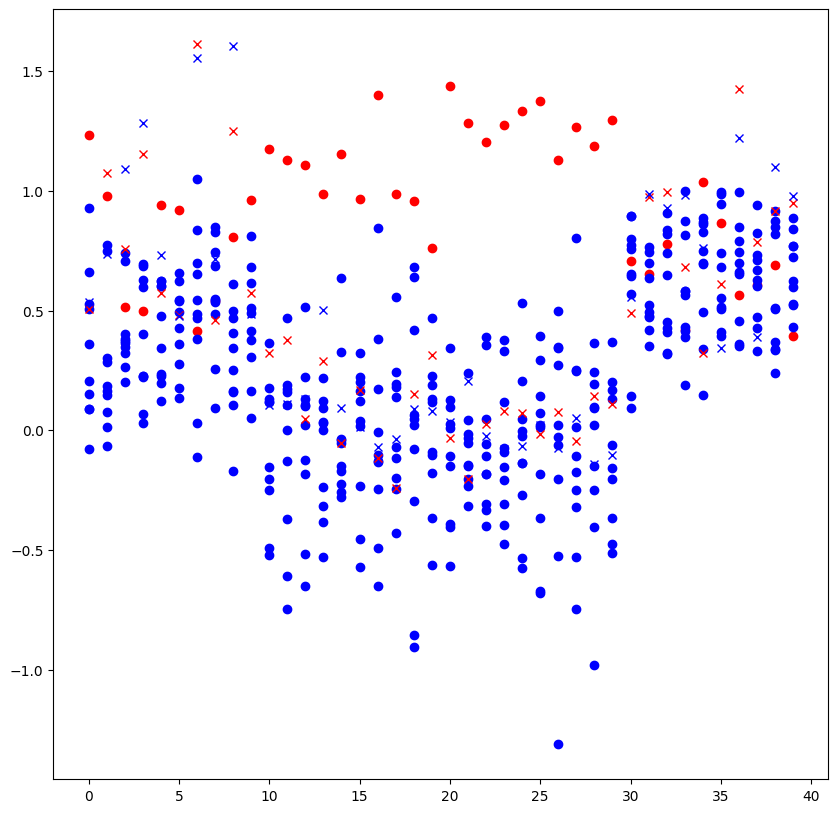

In [318]:
named_params = {name: p for name, p in model.named_parameters() if p.requires_grad}
# print(named_params.keys())

plt.figure(figsize = (10,10))
plt.plot(named_params['LSTM.weight_ih_l0'].detach().cpu().numpy(),linestyle = 'None',marker='o',color='red')
plt.plot(named_params['LSTM.weight_hh_l0'].detach().cpu().numpy(),linestyle = 'None',marker='o',color='blue')
plt.plot(named_params['LSTM.bias_ih_l0'].detach().cpu().numpy(),linestyle = 'None',marker='x',color='red')
plt.plot(named_params['LSTM.bias_hh_l0'].detach().cpu().numpy(),linestyle = 'None',marker='x',color='blue')